# Vehicle Detection

## Initialization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import random
import copy
import tensorflow as tf
from random import shuffle

from skimage import transform
from collections import deque
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label

%matplotlib inline

In [ ]:
import laneline
from image_functions import *
from lane_pipeline import *
from detection_pipeline import *

In [ ]:
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger

## Custom Functions

To keep this norebook cleaner all custom functions were provided in separate .py files.
- image_functions.py contains functions related for image transformations
- laneline.py contains the line class
- lane_pipeline.py contains the pipeline used for lane finding
- detection_pipeline.py contains the pipeline used for vehicle detection

## Dataset Exploration

We are going to use the [Udacity labeled dataset 1](https://github.com/udacity/self-driving-car/tree/master/annotations).

>The dataset includes driving in Mountain View California and neighboring cities during daylight conditions. It contains over 65,000 labels across 9,423 frames collected from a Point Grey research cameras running at full resolution of 1920x1200 at 2hz. The dataset was annotated by CrowdAI using a combination of machine learning and humans.

The dataset are frames from a video of roughly 80 minutes of continuous driving in California and if we are not careful about how we split our data there will be a lot of information leaking from the training set into the validation set and our results will not be representative of the real performance of the pipeline.

After a meticulous analysis of all provided frames, I have selected 998 frames to be our validation set. That would be equivalent of removing a little over 8 minutes of driving from our training data set.

The `truck` and `car` classes were combined into a new `vehicle` class and the bounding boxes for the `pedestrian` class were ignored.

In [ ]:
# We first load the whole csv into a pandas df
data = pd.read_csv('./datasets/deeplearning/mod_labels.csv', 
                      dtype={'xmin':np.float, 'xmax':np.float, 
                             'ymin':np.float, 'ymax':np.float,
                             'Frame':np.str, 'Label':np.str,
                             'Dataset':np.str}, header=0)

# Store the filenames for each sample in the training set and validation set
trn_fn = data[data.Dataset=='Train'].Frame.unique()
val_fn = data[data.Dataset=='Valid'].Frame.unique()

# Sort the filenames, so they are in chronological order
trn_fn = np.sort(trn_fn)
val_fn = np.sort(val_fn)

# And assert that they are all different
assert any(x for x in val_fn if x in trn_fn) is False

### Data pre-processing

During the visual exploration of the dataset it also became evident that many frames are still too similar to each other, even with the video being recorder at 2Hz.

To adress this issue while also being mindful that we will need a large dataset in order to properly train our model, I came up with the following pre-processing steps:

* Skip every other frame to resample our training data to 1Hz.
* Create an image mask for each frame we are going to use (this will make things a lot easier during data augmentation).
* Augment our dataset using random rotations, scalings, translations and crops. 

In [ ]:
# Downsample our training video stream to 1Hz.
trn_fn_1hz = trn_fn[::2]

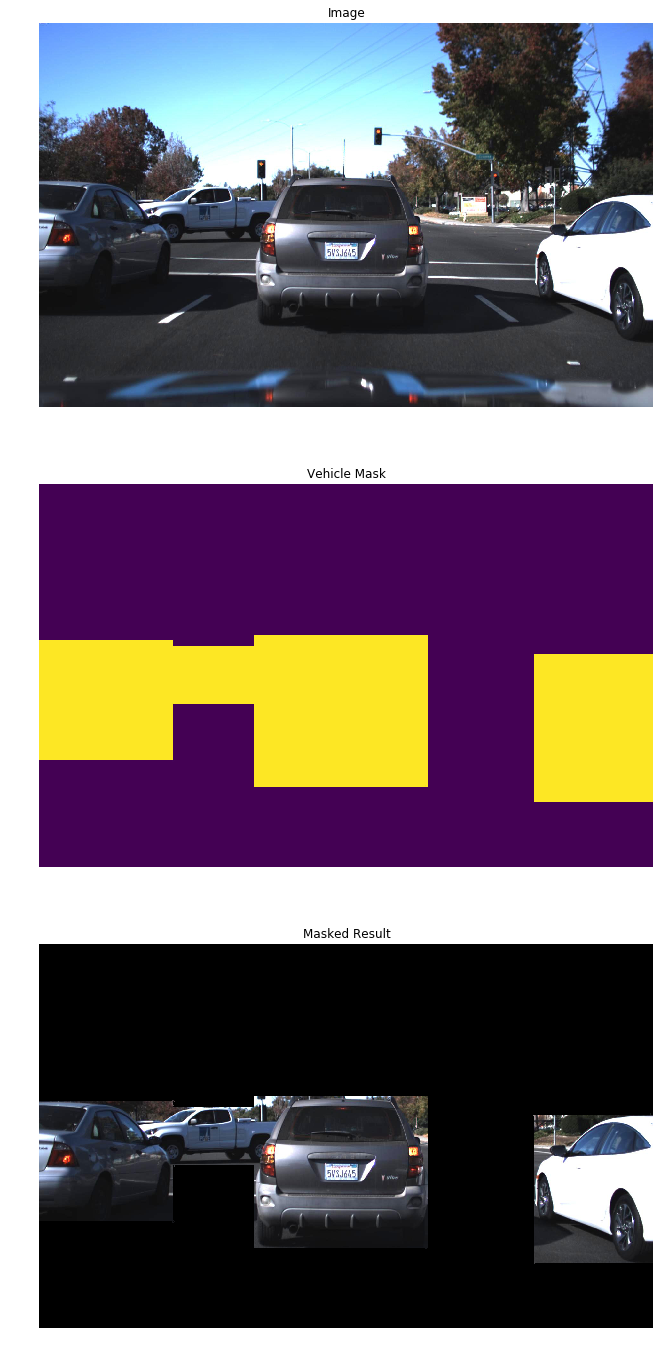

In [6]:
plot_img_mask_from_folder(val_fn[50])

Now that we have image masks with the same dimensions of the input image, we can define a data augmentation pipeline. We apply the same transformations to both the input image and the image mask, ensuring we will always have the exact location of the the vehicles highlighted in the augmented dataset as well.

For the data augmentation parameters I have leveraged from knowledge acquired while implementing our [Traffic Sign Classifier](https://github.com/bguisard/CarND-Traffic-Sign-Classifier-Project).

- Rotation between -15 and 15 degrees
- Scaling between 0.9 and 1.1 times
- Translation between -5% and +5% of image width
- Shear limit between -10 and 10 degrees
- Motion blur kernel size of 3 pixels

On top of those transformations we will also reduce the input size to cut down on computation time. This will be done in two different steps, first scaling the images down to 20% of its original size and randomly cropping the image to 224 x 224 - the same size used by the DenseNet authors to train on ImageNet, so we can leverage from pretrained weights if we want.

The validation set will not receive any augmentation, but will need to be scaled down to the same size as our training dataset. To keep the objects with the same proportion as they are in a live video stream, we will scale down the lower dimension of the image to 224 pixels and do a center crop to fit the other dimension to 224 rather than scaling it down.

You can find below an example of each case.

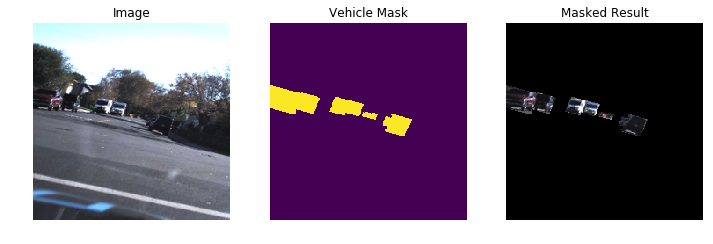

In [8]:
ref = 0

img = cv2.imread('./datasets/deeplearning/udacity/' + trn_fn_1hz[ref], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_mask = cv2.imread('./datasets/deeplearning/masks/mask_' + trn_fn_1hz[ref], cv2.IMREAD_GRAYSCALE)
img_mask = np.reshape(img_mask, (np.shape(img_mask)[0], np.shape(img_mask)[1], 1))

aug_img, aug_mask = preprocess_trn_img(img, img_mask, crop=True, aug=False)
aug_mask = aug_mask.astype(np.uint8)

plot_img_mask(aug_img, aug_mask, figsize=(12, 12), orient=1)

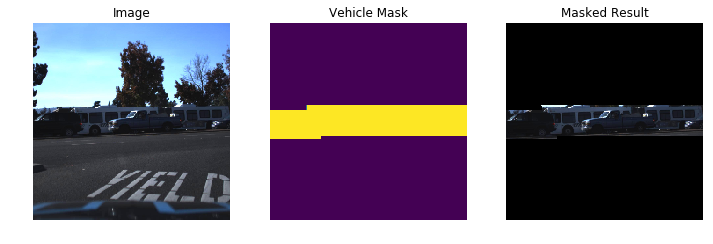

In [9]:
ref = 0

img = cv2.imread('./datasets/deeplearning/udacity/' + val_fn[ref], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_mask = cv2.imread('./datasets/deeplearning/masks/mask_' + val_fn[ref], cv2.IMREAD_GRAYSCALE)
img_mask = np.reshape(img_mask, (np.shape(img_mask)[0], np.shape(img_mask)[1], 1))

val_img, aug_mask = preprocess_val_img(img, img_mask)
val_mask = aug_mask.astype(np.uint8)

plot_img_mask(val_img, val_mask, figsize=(12, 12), orient=1)

With the preprocessing functions validated we can create a Python generator that will feed the images and masks to our model. This will enable us to have as many training images as we want.

Sample images are provided below:

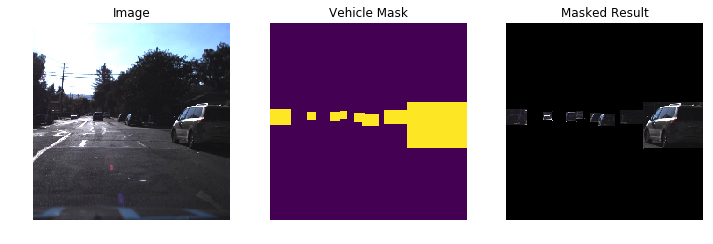

In [56]:
plot_img_mask((test_imgs[0] * 255).astype(np.uint8), (test_masks[0] * 255).astype(np.uint8), figsize=(12, 12), orient=1)

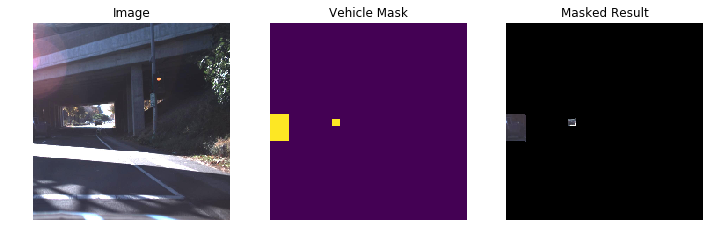

In [57]:
plot_img_mask((test_imgs[1] * 255).astype(np.uint8), (test_masks[1] * 255).astype(np.uint8), figsize=(12, 12), orient=1)

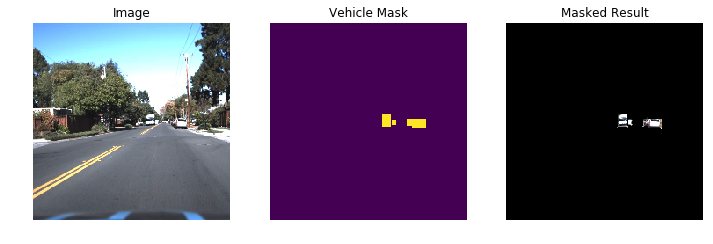

In [58]:
plot_img_mask((test_imgs[2] * 255).astype(np.uint8), (test_masks[2] * 255).astype(np.uint8), figsize=(12, 12), orient=1)

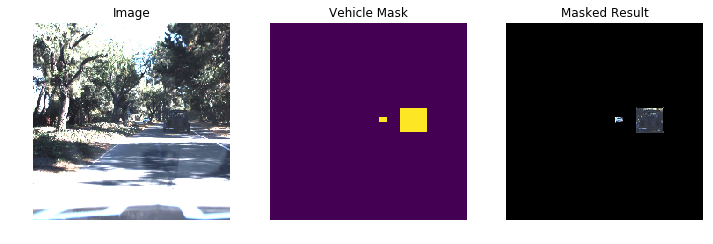

In [59]:
plot_img_mask((test_imgs[3] * 255).astype(np.uint8), (test_masks[3] * 255).astype(np.uint8), figsize=(12, 12), orient=1)

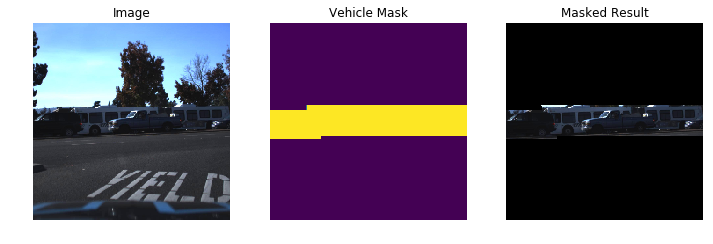

In [22]:
plot_img_mask((test_imgs[0] * 255).astype(np.uint8), (test_masks[0] * 255).astype(np.uint8), figsize=(12, 12), orient=1)

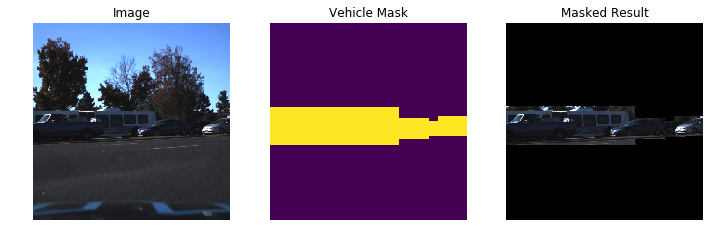

In [23]:
plot_img_mask((test_imgs[1] * 255).astype(np.uint8), (test_masks[1] * 255).astype(np.uint8), figsize=(12, 12), orient=1)

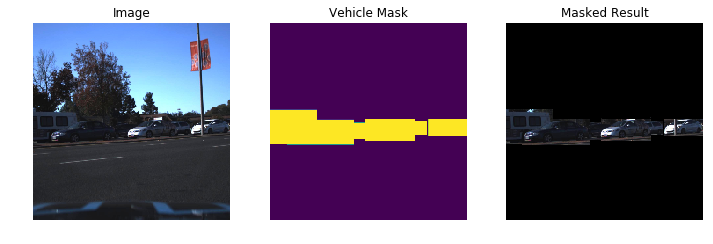

In [24]:
plot_img_mask((test_imgs[2] * 255).astype(np.uint8), (test_masks[2] * 255).astype(np.uint8), figsize=(12, 12), orient=1)

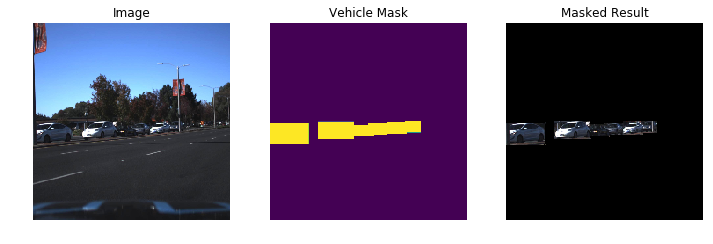

In [25]:
plot_img_mask((test_imgs[3] * 255).astype(np.uint8), (test_masks[3] * 255).astype(np.uint8), figsize=(12, 12), orient=1)

## Densely Connected Convolutional Networks

Also known as `DenseNets`[1] is a fairly new architecture, published in late 2016, that expands ideas introduced by `ResNets`[2], where blocks of convolutional layers receives not only the feature-maps of the previous block, but also it's input as well. Since they are forward feeding not only their outputs, but also their inputs, the optimization process is done on the residuals of each transformation, hence the name Residual Networks.

The biggest changes introduced by DenseNets are that the feature-maps of each block are passed to all subsequent layers of each block and that these feature-maps are concatenated together instead of summed.

>For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several compelling
advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters. We evaluate our proposed architecture on four highly competitive object recognition benchmark tasks (CIFAR- 10, CIFAR-100, SVHN, and ImageNet). DenseNets obtain significant improvements over the state-of-the-art on most of them, whilst requiring less memory and computation to achieve high performance.



![alt text][image1]

source: https://arxiv.org/pdf/1608.06993v3.pdf

[//]: # (Image References)

[image1]: ./images/dense_block.jpg "A dense block example"

## The one hundred layers Tiramisu

Following the great results shown by DenseNets in image classification, Jégou et al. [3] extended the previous work, proposing an architecture for semantic image segmentation that uses several dense blocks during downsampling and upsampling.

The proposed network is called Fully Convolutional DenseNets for Semantic Segmentation, but was also named "The One Hundred Layers Tiramisu" and the diagram below gives a great overview of the architecture.

<img src='./images/tiramisu.jpg' width="480" alt="Fully Convolutional DenseNets for Semantic Segmentation" />


>Diagram of our architecture for semantic segmentation. Our architecture is built from dense blocks. The diagram is com- posed of a downsampling path with 2 Transitions Down (TD) and an upsampling path with 2 Transitions Up (TU). A circle repre- sents concatenation and arrows represent connectivity patterns in the network. Gray horizontal arrows represent skip connections, the feature maps from the downsampling path are concatenated with the corresponding feature maps in the upsampling path. Note that the connectivity pattern in the upsampling and the downsam- pling paths are different. In the downsampling path, the input to a dense block is concatenated with its output, leading to a linear growth of the number of feature maps, whereas in the upsampling path, it is not.

source:https://arxiv.org/pdf/1611.09326v2.pdf

The main architecture described on their work is a 103 layer network, called FC-DenseNet103. The definition of each of the key blocks of the model can be seen below.

>Dense block layers are composed of BN, followed by ReLU, a 3 × 3 same convolution (no resolution loss) and dropout with probability p = 0.2. The growth rate of the layer is set to k = 16.

>Transition down is composed of BN, followed by ReLU, a 1 × 1 convolution, dropout with p = 0.2 and a non-overlapping max pooling of size 2 × 2.

>Transition up is composed of a 3×3 transposed convolution with stride 2 to compensate for the pooling operation.

And the overview of the architecture:

| Architecture                 |
|:----------------------------:|
|Input, m = 3                  |
|3×3 Convolution, m = 48       |
|DB (4 layers) + TD, m = 112   |
|DB (5 layers) + TD, m = 192   |
|DB (7 layers) + TD, m = 304   |
|DB (10 layers) + TD, m = 464  |
|DB (12 layers) + TD, m = 656  |
|DB (15 layers), m = 880       |
|TU + DB (12 layers), m = 1072 |
|TU + DB (10 layers), m = 800  |
|TU + DB (7 layers), m = 560   |
|TU + DB (5 layers), m = 368   |
|TU + DB (4 layers), m = 256   |
|1×1 Convolution, m = c        |
|Softmax                       |

>Architecture details of FC-DenseNet103 model used in our experiments. This model is built from 103 convolutional layers. In the Table we use following notations: DB stands for Dense Block, TD stands for Transition Down, TU stands for Transition Up, BN stands for Batch Normalization and m corresponds to the total number of feature maps at the end of a block. c stands for the number of classes.

source:https://arxiv.org/pdf/1611.09326v2.pdf

In [ ]:
input_shape = (224,224,3)
img_input = Input(shape=input_shape)

#FCN-DenseNet56:
x = get_FCN_DenseNet(img_input, growth_rate=12, p=0.2, init_conv_filters=24, activation='sigmoid')

In [ ]:
model = Model(img_input, x)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
initial_conv2D (Conv2D)      (None, 224, 224, 24)      648       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 24)      96        
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 12)      2592      
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 12)      0         
_________________________________________________________________
concatenate_1 (Concatenate)  (None, 224, 224, 36)      0         
__________

### Overfit to small data

In [ ]:
# Overfit small data to ensure model can learn
optimizer = RMSprop(lr=1e-3, decay=0.995)
model.compile(optimizer, loss=IOU_loss, metrics=[IOU_calc])
model.fit(test_imgs, test_masks, epochs=2000, verbose=0, batch_size=2)

In [ ]:
test_pred = model.predict(test_imgs)

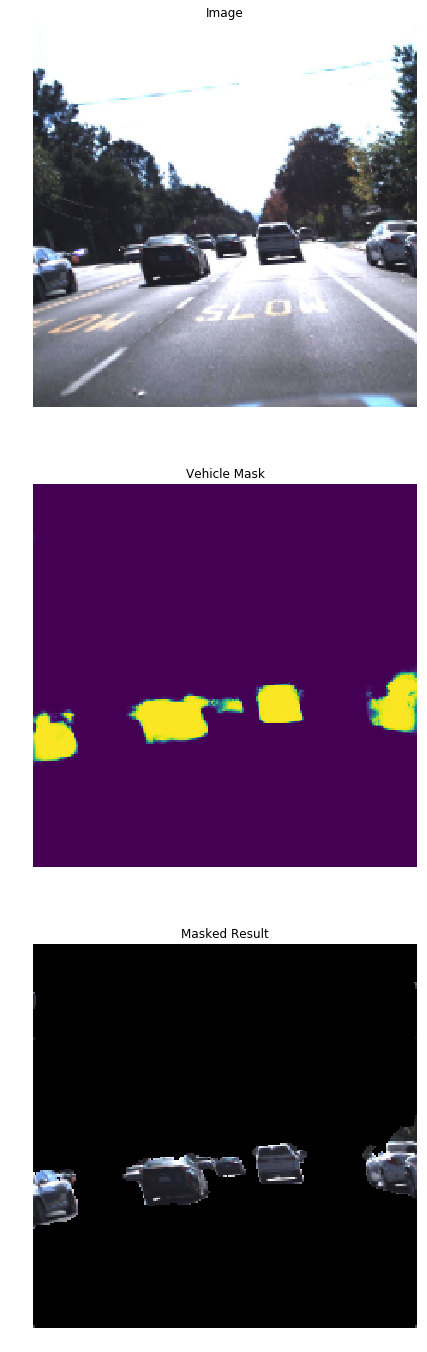

In [29]:
plot_img_mask((test_imgs[0] * 255).astype(np.uint8), (test_pred[0] * 255).astype(np.uint8), figsize=(24, 24), orient=0)

### Training on the whole dataset

Once our model is overfitting on a toy dataset we are confident that, at least in theory, it should be able to learn when trained on the whole dataset.

At this point we also leverage of Keras' callbacks function to save the model state after every epoch, so we can easily navigate through the many iterations and go back in case it starts overfitting on the real dataset.

In [ ]:
model = Model(img_input, x)

optimizer = RMSprop(lr=1e-3, decay=0.995)
model.compile(optimizer, loss=weigthed_binary_crossentropy(50), metrics=[IOU_calc])

callbacks = [ModelCheckpoint('./models/FCN56.{epoch:02d}-{val_loss:.2f}.hdf5'), CSVLogger('./models/FCN56.csv')]

trn_generator = generator(trn_fn_1hz, batch_size=4)
val_generator = generator(val_fn, batch_size=4, valid=True)

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer, loss=weigthed_binary_crossentropy(50), metrics=[IOU_calc])

In [ ]:
trn_generator = generator(trn_fn_1hz, batch_size=4, aug=False)
val_generator = generator(val_fn, batch_size=4, valid=True)

In [ ]:
model.fit_generator(trn_generator,
                    epochs=5,
                    steps_per_epoch=1000,
                    validation_data=val_generator,
                    validation_steps=1000,
                    callbacks=callbacks,
                    verbose=0)

In [ ]:
#model.save_weights('./models/FCN56.h5')

In [ ]:
model.load_weights('./models/FCN56.h5')

In [ ]:
test_pred = model.predict_generator(val_generator, steps=len(val_fn) // 16 + 1)

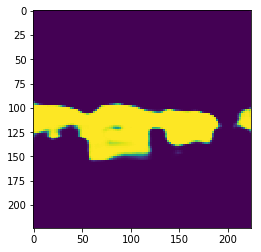

In [85]:
plt.imshow(test_pred[3][:,:,0])

### Fine tune on non-cropped images

After reaching satisfactory results on the smaller sized images, the next step would be to fine-tune using full sized images. Since the resolution of the input images were too large to fit in our GPU, I have decided to fine tune on small images, but with similar aspect ratio as our input images (instead of the 224 x 224 square images we were using for training above)

In [ ]:
input_shape_lg = (224, 352, 3)
img_input_lg = Input(shape=input_shape_lg)
x_lg = get_FCN_DenseNet(img_input_lg, input_shape=input_shape_lg, growth_rate=12, p=0.2,
                        init_conv_filters=24, activation='sigmoid', upsampling_type='upsampling')

In [ ]:
model_large = Model(img_input_lg, x_lg)

In [ ]:
optimizer_lg = Adam(lr=1e-4)
model_large.compile(optimizer_lg, loss=IOU_loss, metrics=[IOU_calc])

In [ ]:
callbacks = [ModelCheckpoint('./models/FCN56_lg.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True), CSVLogger('./models/FCN56_lg.csv')]

In [ ]:
trn_generator_full = generator(trn_fn_1hz, batch_size=4, tgt_sz=(224, 352), crop_sz=(224, 352), crop=False, aug=False)
val_generator_full = generator(val_fn, batch_size=4, valid=True, tgt_sz=(224, 352), crop_sz=(224, 352))

In [ ]:
model_large.fit_generator(trn_generator_full,
                          epochs=40,
                          steps_per_epoch=1000,
                          validation_data=val_generator_full,
                          validation_steps=1000,
                          callbacks=callbacks,
                          verbose=0)

In [ ]:
#model_large.save_weights('./models/FCN56_lg_final.h5')

In [ ]:
model_large.load_weights('./models/FCN56_lg.37--0.82.hdf5')

### Run on the test video

In [ ]:
images, filenames = read_all_imgs('./video_frames/test/')

order = np.argsort(filenames)
images = np.array(images)[order]
filenames = np.array(filenames)[order]

In [ ]:
rsz_images = []
for img in images:
    rsz = cv2.resize(img, (352, 224))
    rsz_images.append(rsz)

rsz_images = np.array(rsz_images) / 255

In [ ]:
tst_masks = model_large.predict(rsz_images, batch_size=4)

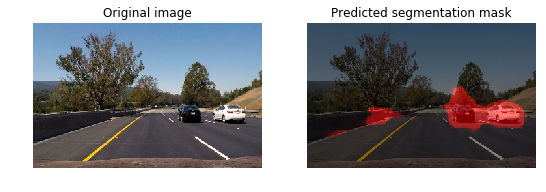

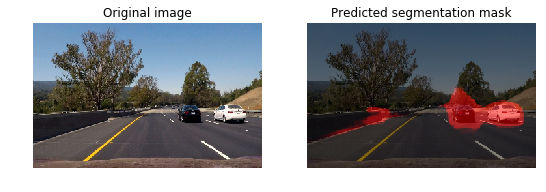

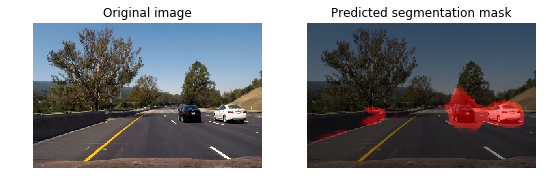

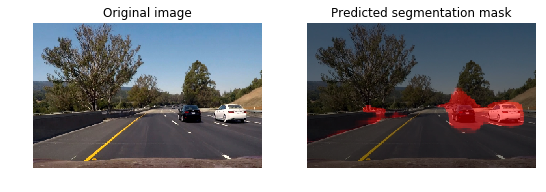

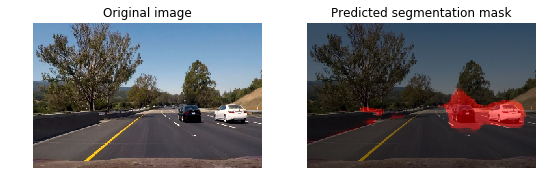

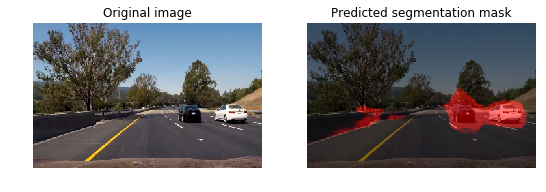

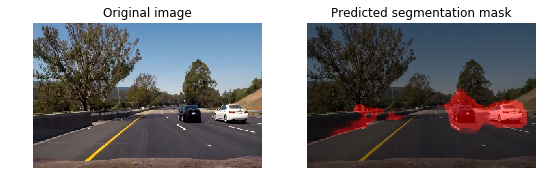

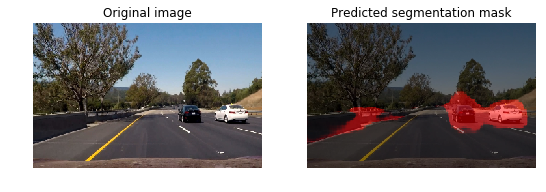

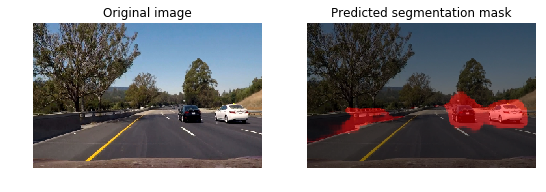

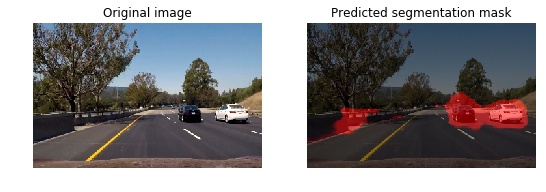

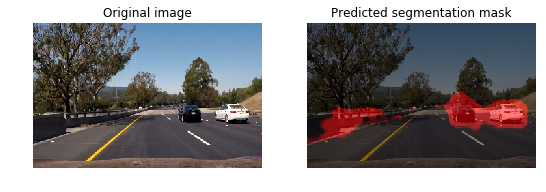

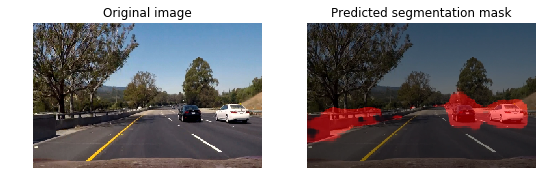

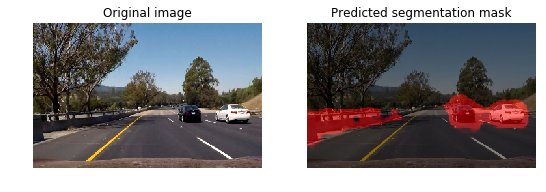

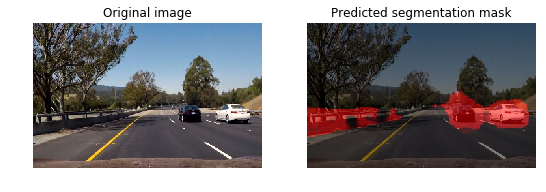

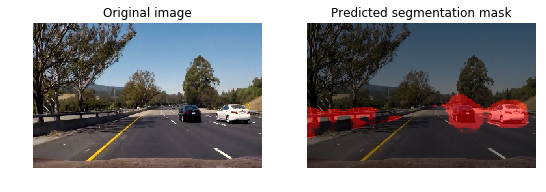

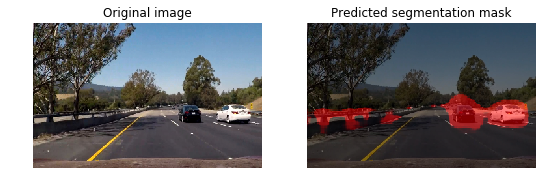

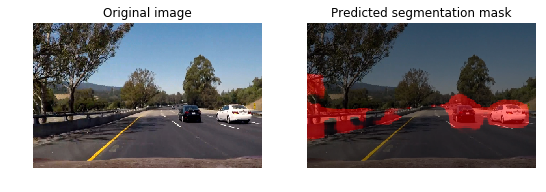

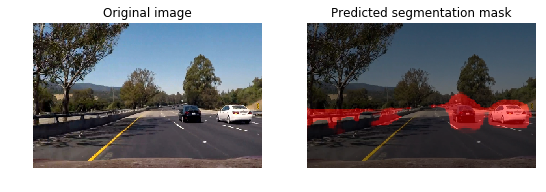

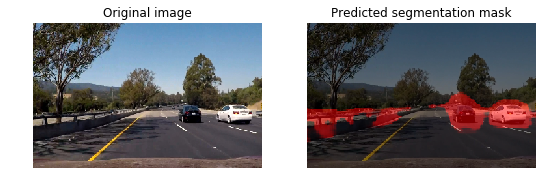

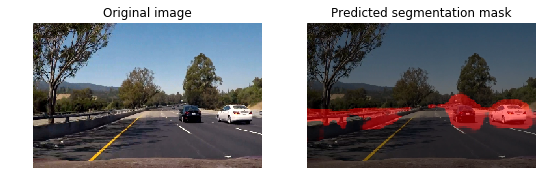

In [187]:
for i in range(20):
    
    im = np.array(255*rsz_images[i],dtype=np.uint8)
    im_pred = np.array(255*tst_masks[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    
    plt.figure(figsize=(9,6))
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.show()

Jégou et al. reported a mean IoU (intersection over union) accuracy of 73.2% for the car class, while using the FC-DenseNet56 architecture, but the overall model accuracy was 88.9%. It took us 60 epochs (roughly 10 hours) to get to 72.3% in a different dataset, but we were optimizing for just one class, so there was clearly room for improvement.

During the first attempts to train our model, the IoU loss was not efficient in training the model, but after the first 10h of optimization, it had a better idea of where the vehicles were, so I decided to train again, but this time using IoU as loss function and targeting a similar performance than the authors.

After 40 epochs the validation loss was constantly above 86% and I decided to stop training, but it is possible that it would continue to improve if it had more time to train.

The results after the last training effort can be seen below:

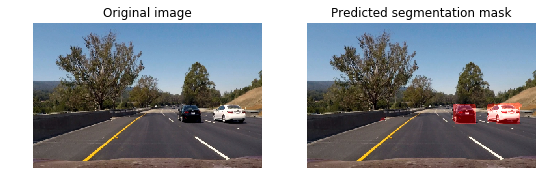

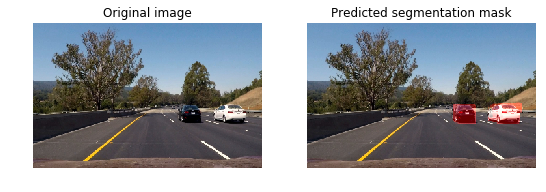

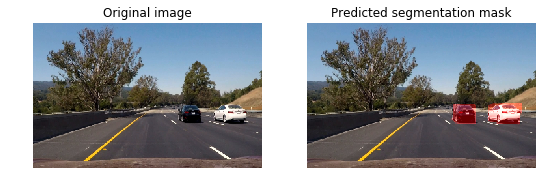

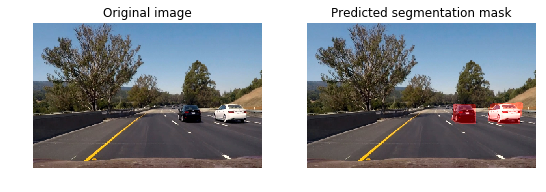

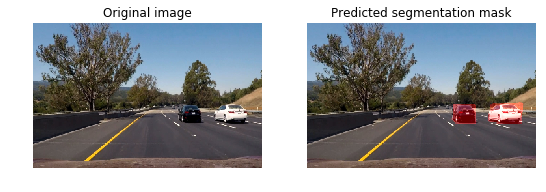

In [405]:
for i in range(5):
    
    im = np.array(255*rsz_images[i],dtype=np.uint8)
    im_pred = np.array(255*tst_masks[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred, 0.4, im, 1, 0)
    
    plt.figure(figsize=(9,6))
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.show()

## First run on video

With a very strong performance on the validation set, I tested the model on the provided video and the results were very good, proving that the validation set was properly created and that there was no leakage of information from training into validation. 

The model was able to detect the location of vehicles accurately in all lanes, but it encountered some difficulties in scenarios that were not in the training set (e.g change in light conditions and trash on the side of the highway).

## Fine tuning

To address those minor details I have curated a fine tuning set of 48 frames and retrained the model with a very low learning rate (1e-5) over 10 epochs. A sample of the images selected and the modified masks can be seen below:

In [ ]:
new_ft_image_set_test = load_array('new_ft_image_set.dat')
new_ft_mask_set_test = load_array('new_ft_mask_set.dat')

In [ ]:
new_ft_image_set_test = np.array(new_ft_image_set_test) / 255
new_ft_mask_set_test = np.array(new_ft_mask_set_test) / 255

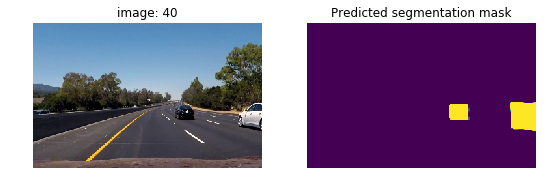

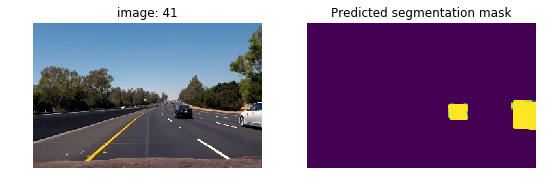

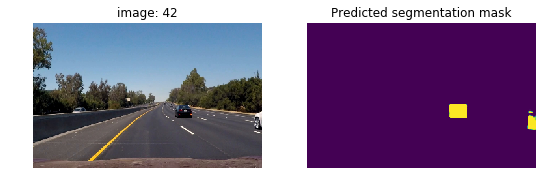

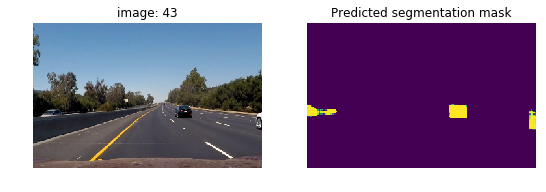

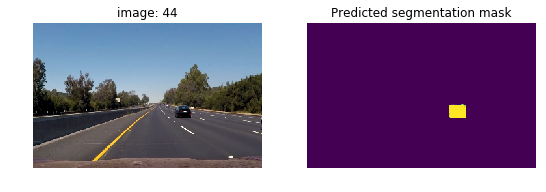

In [698]:
start = 40
examples = 5

for i in range(examples):
    
    im = new_ft_image_set_test[start + i]
    mask = new_ft_mask_set_test[start + i][:,:,0]
    
    plt.figure(figsize=(9,6))
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.title('image: {}'.format(start+i))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.show()

### Fine tuning network

In [ ]:
x_lg_ft = get_FCN_DenseNet(img_input_lg, input_shape=input_shape_lg, growth_rate=12, p=0.2,
                           init_conv_filters=24, activation='sigmoid', upsampling_type='upsampling')

In [ ]:
model_large_ft = Model(img_input_lg, x_lg_ft)

In [ ]:
optimizer_lg_ft = Adam(lr=1e-5)
model_large_ft.compile(optimizer_lg_ft, loss=IOU_loss, metrics=[IOU_calc])

In [ ]:
callbacks_ft = [ModelCheckpoint('./models/FCN56_lg_ft.{epoch:02d}-{loss:.2f}.hdf5', save_best_only=True), CSVLogger('./models/FCN56_lg_ft.csv')]

In [ ]:
model_large_ft.fit(new_ft_image_set_test, new_ft_mask_set_test,
                   batch_size=4, epochs=10, verbose=0, callbacks=callbacks_ft )

In [ ]:
#model_large_ft.save_weights('./models/FCN56_lg_ft.h5')

In [ ]:
model_large_ft.load_weights('./models/FCN56_lg_ft.h5')

## Video processing

In [ ]:
def process_image(image):

    # First we will call the laneline pipeline
    lanes = new_video_pipeline(image, leftline, rightline)

    # And then the vehicle detection
    result = vehicle_detection(image, model_large_ft, lanes=lanes, bbox_min_sz=(50, 50))

    return result

In [ ]:
leftline = laneline.Line(name='left', dist_thres=0, slope_thres=0, curv_thres=0.6)
rightline = laneline.Line(name='right',dist_thres=0, slope_thres=0, curv_thres=0.6)

project_output = './video_output/project_video.mp4'
clip2 = VideoFileClip("project_video.mp4")

easy_clip = clip2.fl_image(process_image)

%time easy_clip.write_videofile(project_output, audio=False)